# This notebook uses Python 3

In [1]:
%matplotlib inline

from pyIHACRES import ihacres_funcs
from pyIHACRES.Network import Network
from pyIHACRES.Network import StreamNode, DamNode
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
climate_data = pd.read_table('Murrindindi.dat', index_col=0, dayfirst=True, parse_dates=True)
climate_data.rename(columns={'P': 'Murrindindi_rain', 'E': 'Murrindindi_evap', 'Q': 'streamflow'}, inplace=True)

In [3]:
net = Network.load_network('network.yml', first_node='Murrindindi')

hist_levels = climate_data['streamflow'].values

ext_data = np.array(np.zeros(len(climate_data['Murrindindi_rain'])), dtype=[('Murrindindi_irrig', float), ])

In [4]:
target_node = net.network['Murrindindi']
timesteps = len(climate_data)
for ts_idx in range(timesteps):       
    target_node.run(ts_idx, climate_data, ext_data)
# End for

In [22]:
from scipy import optimize
from sklearn.metrics import r2_score, mean_squared_error


level_store = []
metric_score = []
score = -1e6

def obj_func(x_val, net, climate_data, ext_data, hist_levels):
    
    d, d2, e, f, scoef, alpha, a, b, flow_mod = x_val
    
    # e = 1.0  # set `e` as constant as we're feeding in ET data
    
    net.reset()
    network = net.network
    
    target_node = network['Murrindindi']
    target_node.set_calib_params((d, d2, e, f), scoef, alpha, a, b, flow_mod)

    timesteps = len(climate_data)
    for ts_idx in range(timesteps):       
        target_node.run(ts_idx, climate_data, ext_data)
    # End for

#     metric_mse = mean_squared_error(hist_levels, target_node._outflow)
#     metric_rmse = np.sqrt(metric_mse)
    # metric_r2 = r2_score(hist_levels, target_node._outflow, sample_weight=None, multioutput='uniform_average')
    metric_nse = np.sum((hist_levels - target_node._outflow)**2) / np.sum((hist_levels - np.mean(hist_levels))**2)
    
    metric = metric_nse
    
    global score
    global metric_score
    if metric > score:
        global level_store
        level_store.append(target_node._outflow[:])
        score = metric
    # End if
    metric_score.append(score)
    
    return metric
# End obj_func()
    

def calib(x):
    
    d = (100.0, 550.0)
    d2 = (1.5, 20.0)
    e = (0.8, 1.1)
    f = (0.2, 1.3)
    scoef = (0.0, 3.0)
    alpha = (0.1, 0.9)
    a = (1.0, 100.0)
    b = (0.01, 2.0)
    flow_mod = (1.0, 1.0)
#     flow_mod2 = (1.0, 3.0)
    
    bnds = [d, d2, e, f, scoef, alpha, a, b, flow_mod]
    
    res = optimize.minimize(obj_func, x, method='L-BFGS-B', bounds=bnds, 
                            args=(net, climate_data, ext_data, hist_levels, ),)
    return res
# End calib()

# initial node vals
# d, d2, e, f, scoef, alpha, a, b, flow_mod
x_0 = [150, 2.0, 1.0, 0.78, 2.0, 0.5, 54.352, 0.05, 1.0]
res = calib(x_0)

In [23]:
res

      fun: 67.0307565872819
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.11025178e-01,  4.43256657e+02, -1.43895998e+02, -1.08111225e+03,
        0.00000000e+00,  7.81602694e+00,  3.74313913e-03, -2.76511074e+01,
        0.00000000e+00])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 2010
      nit: 19
   status: 2
  success: False
        x: array([1.49859894e+02, 1.61433094e+00, 1.01471413e+00, 6.27028368e-01,
       2.50000000e+00, 1.39898238e-01, 5.43562934e+01, 2.24802879e-02,
       1.00000000e+00])

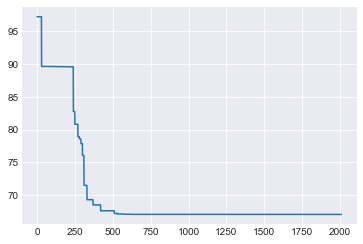

In [24]:
plt.plot(metric_score)

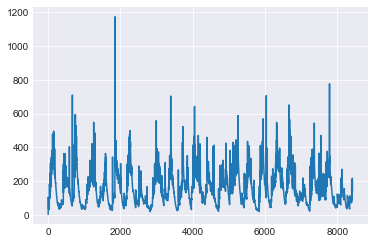

In [25]:
plt.plot(net.network['Murrindindi']._outflow)

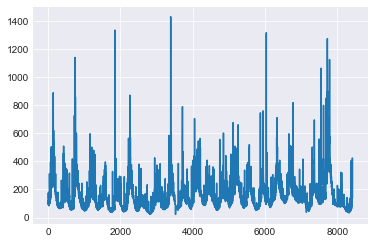

In [26]:
plt.plot(hist_levels)

In [27]:
comparison = {
    'modelled': net.network['Murrindindi']._outflow,
    'historical': hist_levels
}

dataset = pd.DataFrame(comparison)

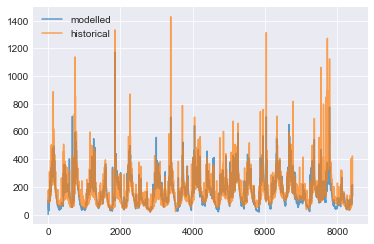

In [28]:
ax = dataset.plot(alpha=0.7);

In [29]:
res.x

array([1.49859894e+02, 1.61433094e+00, 1.01471413e+00, 6.27028368e-01,
       2.50000000e+00, 1.39898238e-01, 5.43562934e+01, 2.24802879e-02,
       1.00000000e+00])

In [30]:
d, d2, e, f, scoef, alpha, a, b, flow_mod = res.x

In [31]:
d, d2, e, f, scoef, alpha, a, b, flow_mod
# Score of 68.30
# (150.00083841239066,
#  1.92658404363843,
#  1.0301907826367998,
#  0.6941978966110686,
#  2.5,
#  0.19311788180355863,
#  54.351958126115946,
#  0.02220702824997326,
#  1.0)

(149.85989358983034,
 1.6143309405110953,
 1.0147141346202997,
 0.6270283683081647,
 2.5,
 0.13989823787335032,
 54.356293400704786,
 0.022480287875453957,
 1.0)

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload

In [ ]:
net = Network.load_network('network.yml', first_node='Murrindindi')

In [ ]:
net.reset()
target_node = net.network['Murrindindi']
ext_data['Murrindindi_irrig'] = 0.0
timesteps = len(climate_data)
for ts_idx in range(timesteps):
    target_node.run(ts_idx, climate_data, ext_data)
# End for

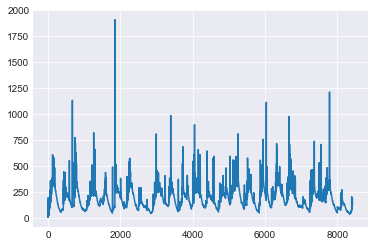

In [88]:
plt.plot(target_node._outflow)

In [9]:
import pickle

In [10]:
with open('murrin_model.pkl', 'wb') as out:
    pickle.dump(net, out)

In [26]:
import pickle
with open('murrin_model.pkl', 'rb') as in_file:
    murrin = pickle.load(in_file)
# End with

node = murrin.network['Murrindindi']

In [30]:
node.run